In [13]:
import pymc3 as pm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import janitor
import seaborn as sns

sns.set_context('talk')
sns.set_style('white')

%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In this notebook, I will simulate data that we will use to answer a "click data" question.

The question at hand is this: We want to run an experiment on our website, in which we measure the conversion rate of our customers. Our customers are searching for flights, and we have collected the number of clicks that they have made before making their purchases.

In [2]:
import pandas_flavor as pf

@pf.register_dataframe_method
def find_replace(df, column, mapper):
    df = df.copy()
    df[column] = df[column].apply(lambda x: mapper.get(x, x))
    return df


mapper = {'ctrl': 0, 'grp1': 1, 'grp2': 2}

In [3]:
# Experiment 1 Parameters
p_1 = 0.06  # 94% of customers do not click anything at all.
mu_1 = 2  # mu/(mu+alpha) gives probability of success at each click.
alpha_1 = 6  # number of clicks until stopping
# (the probability of successfully buying per trial is 6/8)

# Experiment 2 Parameters
p_2 = 0.11
mu_2 = 3  
alpha_2 = 4

# Experiment 3 Parameters
p_3 = 0.13
mu_3 = 1
alpha_3 = 3

In [4]:
with pm.Model() as expt1_sim:
    ctrl = pm.ZeroInflatedNegativeBinomial('ctrl', mu=mu_1, alpha=alpha_1, psi=p_1)
    grp1 = pm.ZeroInflatedNegativeBinomial('grp1', mu=mu_2, alpha=alpha_2, psi=p_2)
    grp2 = pm.ZeroInflatedNegativeBinomial('grp2', mu=mu_3, alpha=alpha_3, psi=p_3)

In [5]:
data = (
    pd.DataFrame(pm.sample_prior_predictive(3000, expt1_sim))
    .melt(
        id_vars=None, 
        value_vars=['ctrl', 'grp1', 'grp2'],
        var_name='experiment_group',
        value_name='clicks'
    )
    .label_encode('experiment_group')
)

In [6]:
print(data.query("clicks != 0").select_columns(['experiment_group', 'clicks']).sample(10))

     experiment_group  clicks
4612             grp1       4
4856             grp1       7
3736             grp1       1
7784             grp2       3
153              ctrl       1
4451             grp1       2
7970             grp2       1
7827             grp2       2
6513             grp2       2
3904             grp1       4


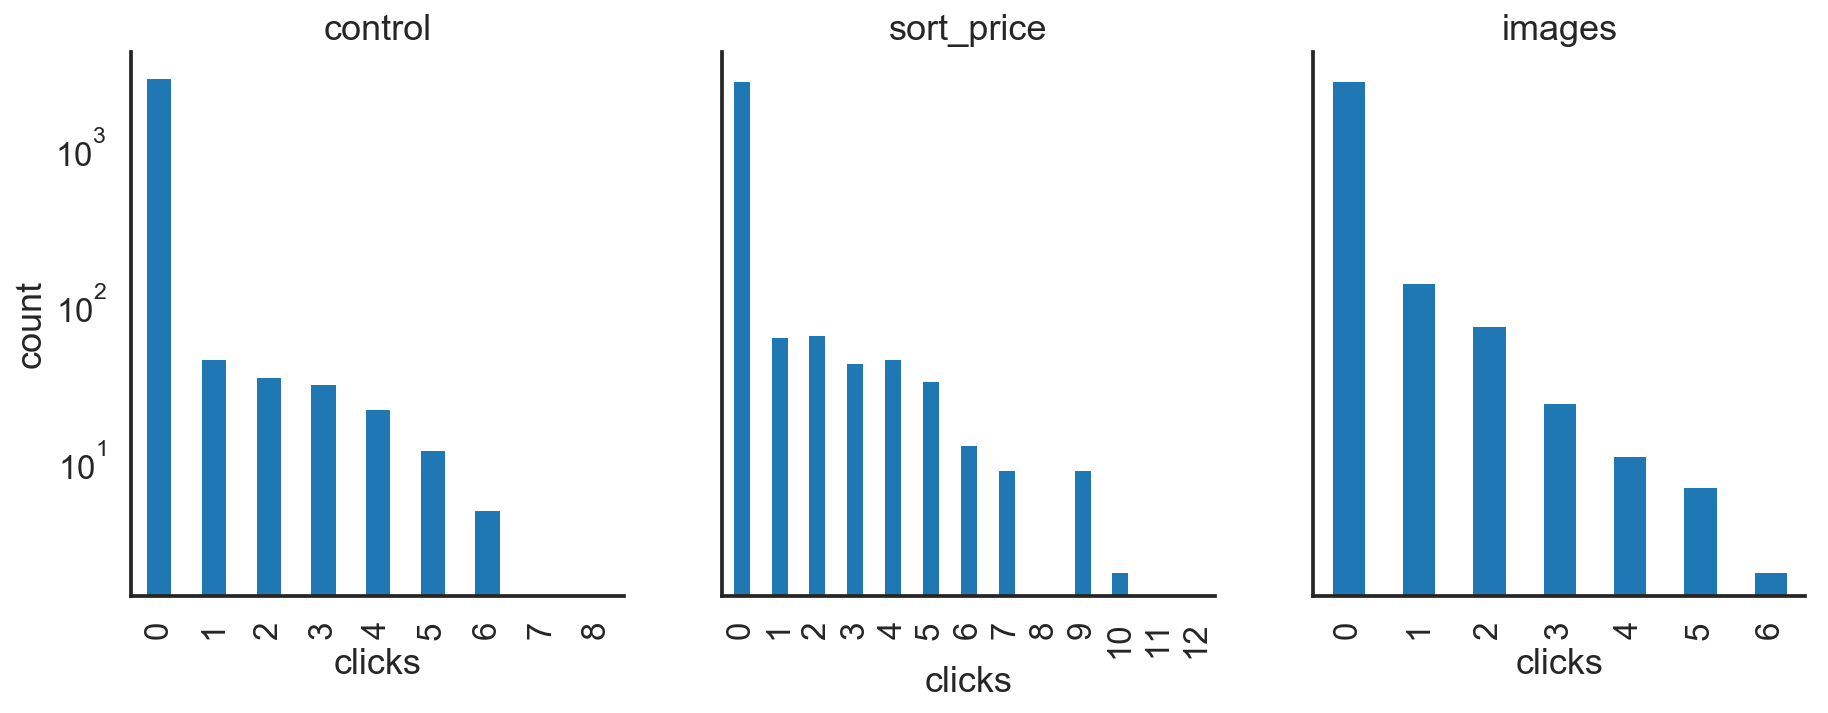

In [53]:
fig, axes = plt.subplots(figsize=(15, 5), nrows=1, ncols=3, sharey=True)
axes[0] = data.query('experiment_group == "ctrl"').groupby('clicks').count()['experiment_group'].plot(kind='bar', ax=axes[0])
axes[0].set_ylabel('count')
axes[0].set_yscale('log')
axes[0].set_title('control')

axes[1] = data.query('experiment_group == "grp1"').groupby('clicks').count()['experiment_group'].plot(kind='bar', ax=axes[1])
axes[1].set_title('sort_price')
axes[2] = data.query('experiment_group == "grp2"').groupby('clicks').count()['experiment_group'].plot(kind='bar', ax=axes[2])
axes[2].set_title('images')

sns.despine()

plt.savefig('../assets/images/clicks.png', dpi=300, bbox_inches='tight', transparent=True)

In [36]:
with pm.Model() as model:
    mu_prior_lam = pm.HalfCauchy('mu_prior_lam', beta=1)
    mu = pm.HalfNormal('mu', sd=mu_prior_lam, shape=(3,))
    mu_enc = mu[data['experiment_group_enc']]

    alpha_prior_lam = pm.HalfCauchy('alpha_prior_lam', beta=1)
    alpha = pm.HalfNormal('alpha', sd=alpha_prior_lam, shape=(3,))
    alpha_enc = alpha[data['experiment_group_enc']]
    
    # Model the probability of purchasing.
    p_purchase = pm.Deterministic('p_purchase', alpha / (mu + alpha))  

    p = pm.Beta('p', alpha=1, beta=1, shape=(3,))
    p_enc = p[data['experiment_group_enc']]
    
    like = pm.ZeroInflatedNegativeBinomial('like', mu=mu_enc, alpha=alpha_enc, psi=p_enc, observed=data['clicks'])

/Users/maer3/anaconda/envs/abcde-testing/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


In [37]:
with model:
    trace = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p, alpha, alpha_prior_lam, mu, mu_prior_lam]
Sampling 4 chains:   0%|          | 0/10000 [00:00<?, ?draws/s]/Users/maer3/anaconda/envs/abcde-testing/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/maer3/anaconda/envs/abcde-testing/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an erro

In [38]:
import arviz as az

/Users/maer3/anaconda/envs/abcde-testing/lib/python3.7/site-packages/arviz/data/io_pymc3.py:56: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  chain_likelihoods.append(np.stack(log_like))
/Users/maer3/anaconda/envs/abcde-testing/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


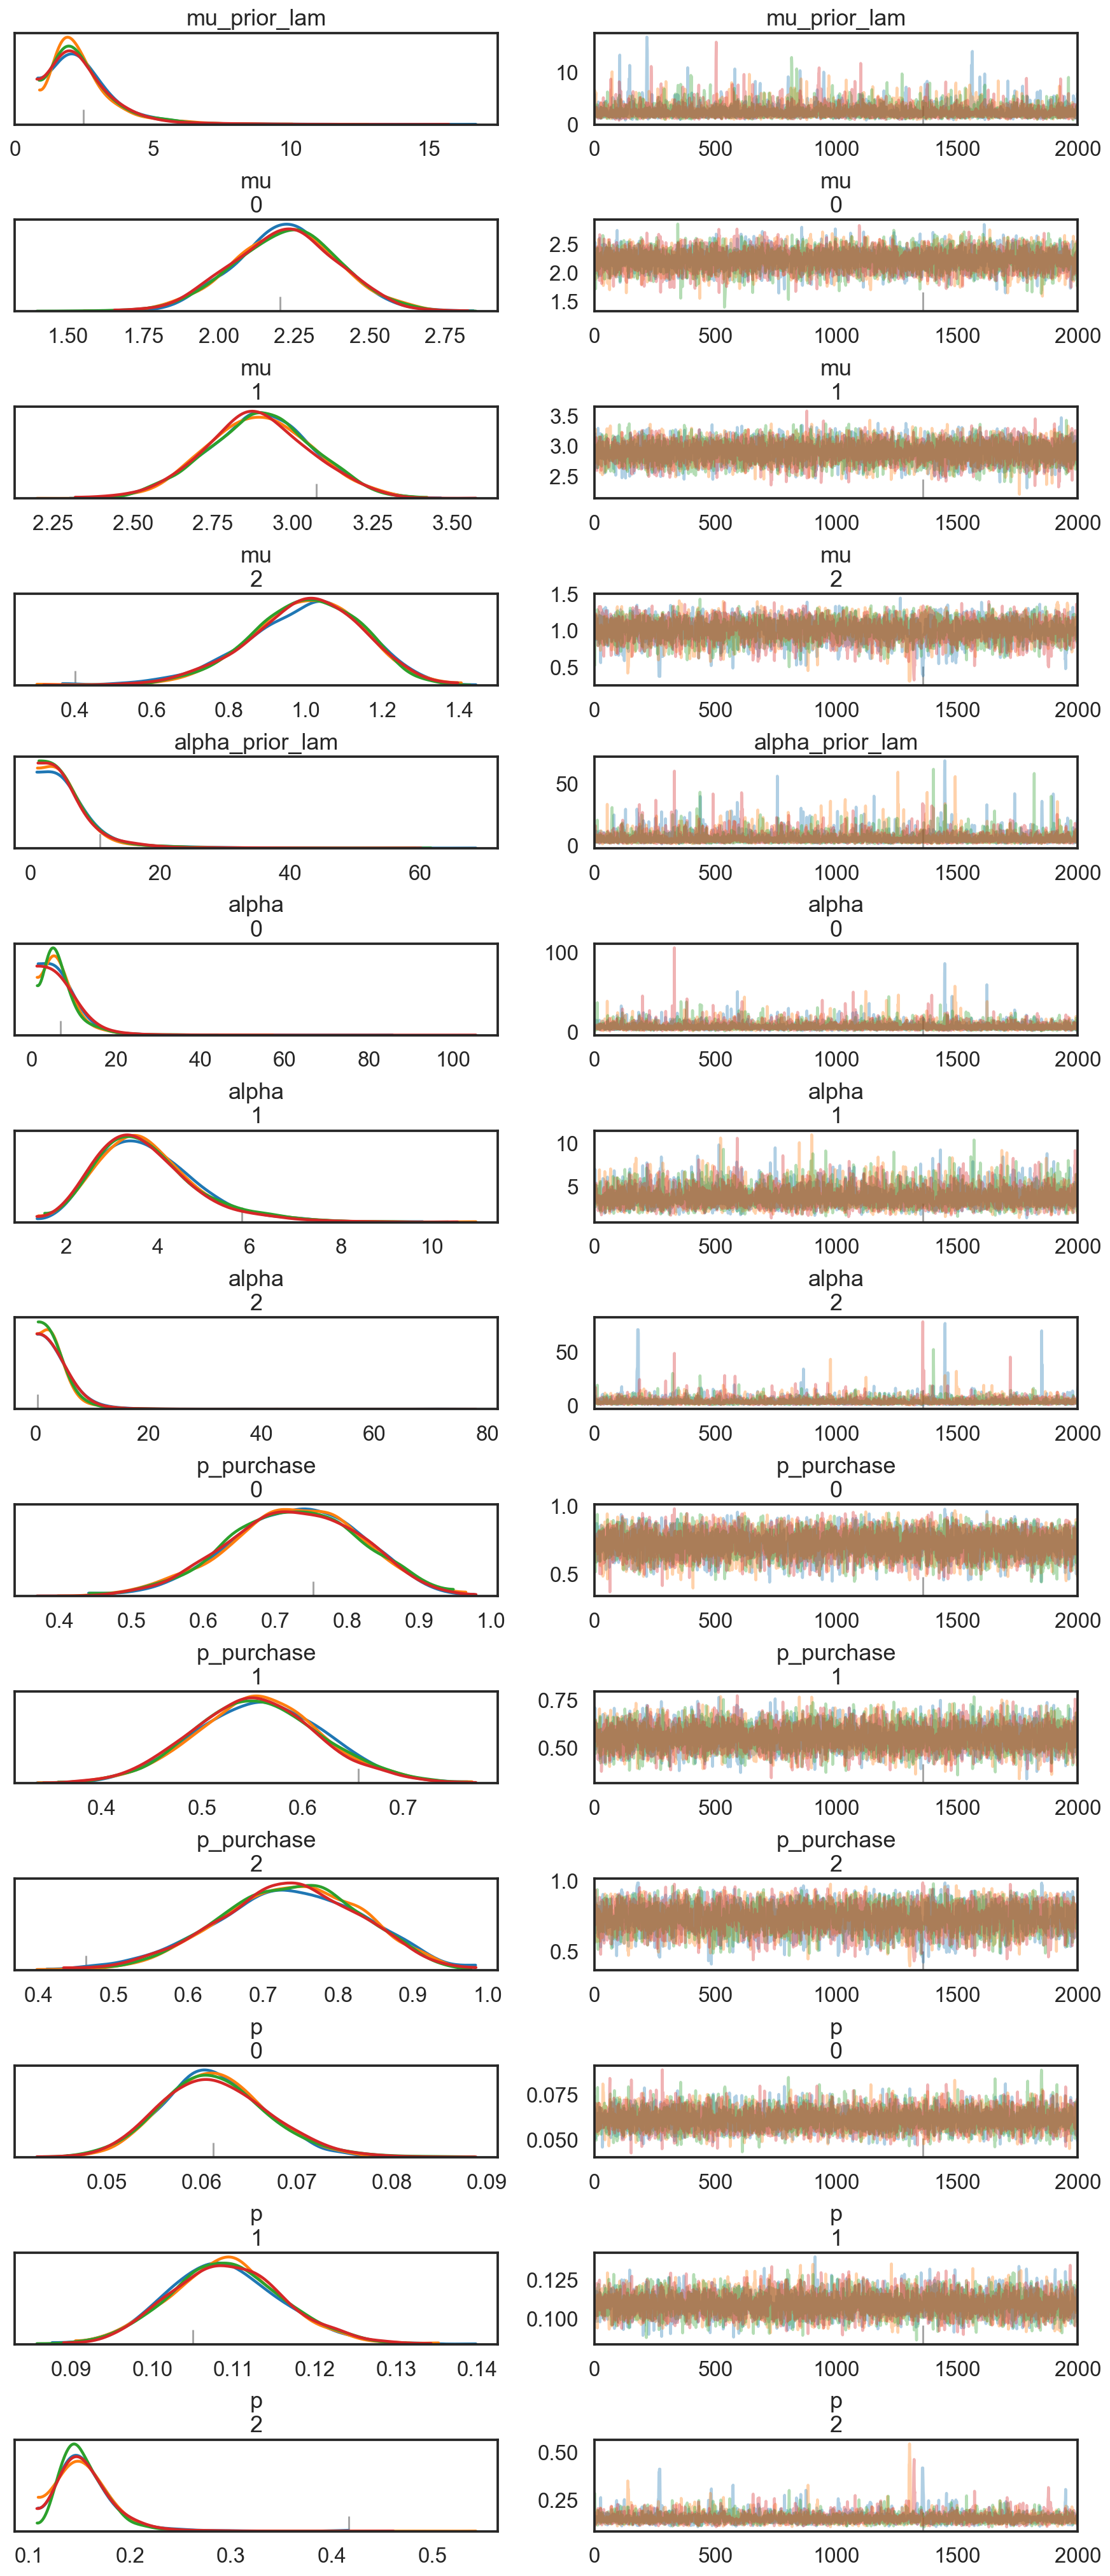

In [39]:
az.plot_trace(trace)
plt.savefig('../assets/images/click.posterior.trace.png', dpi=300, transparent=True)

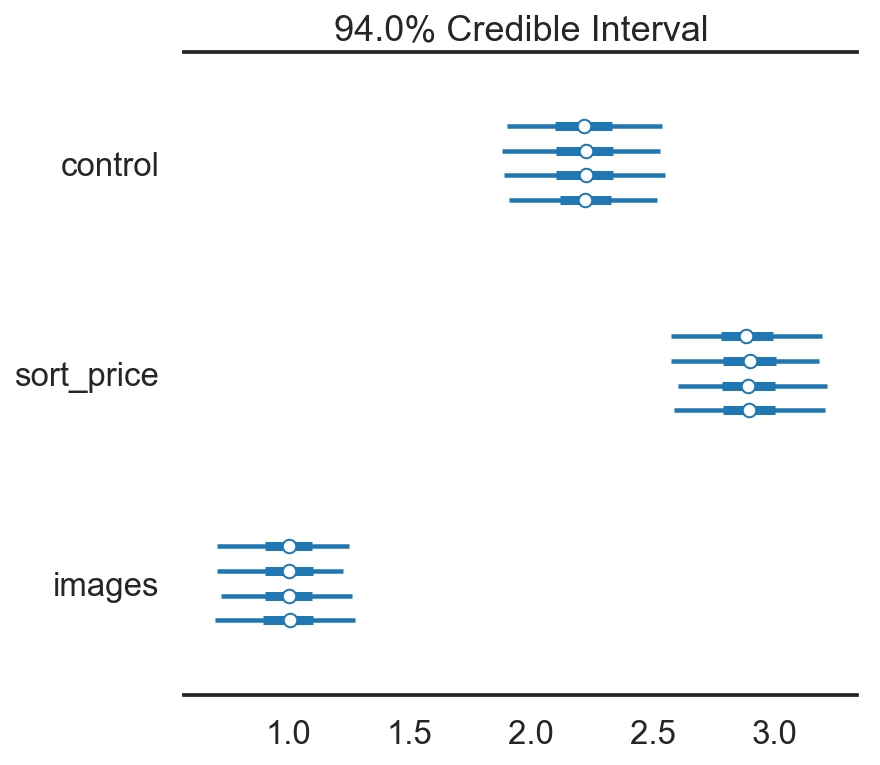

In [51]:
az.plot_forest(trace, var_names=['mu'])
ax = plt.gca()
ax.set_yticklabels(reversed(['control', 'sort_price', 'images']))
plt.savefig('../assets/images/click.mu.forest.png', dpi=300, transparent=True)

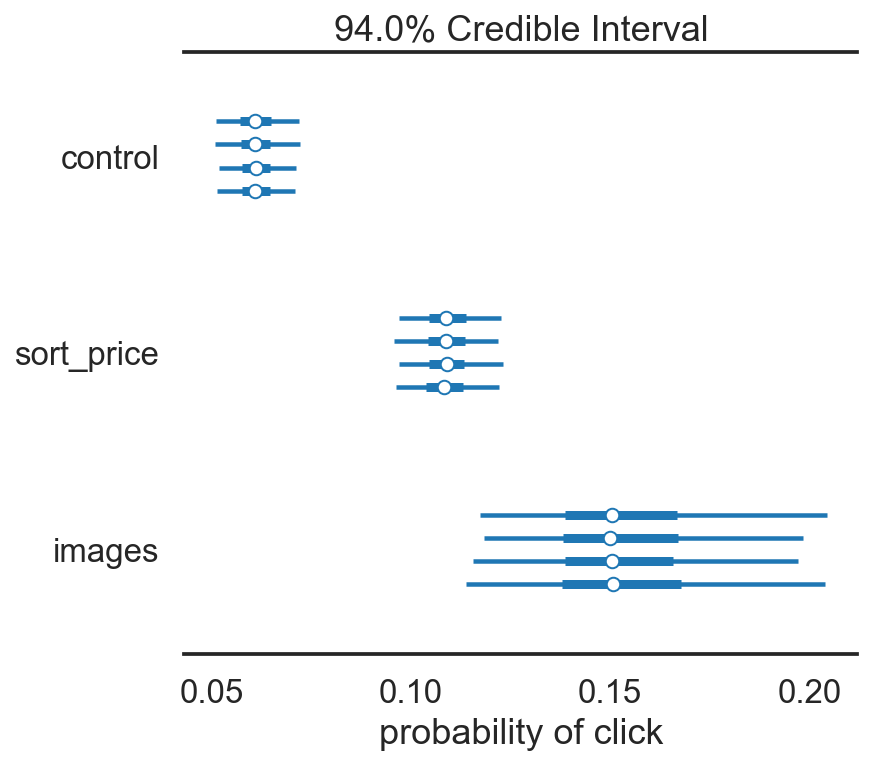

In [54]:
az.plot_forest(trace, var_names=['p'])
ax = plt.gca()
ax.set_yticklabels(reversed(['control', 'sort_price', 'images']))
ax.set_xlabel('probability of click')
plt.savefig('../assets/images/click.p.forest.png', dpi=300, transparent=True)

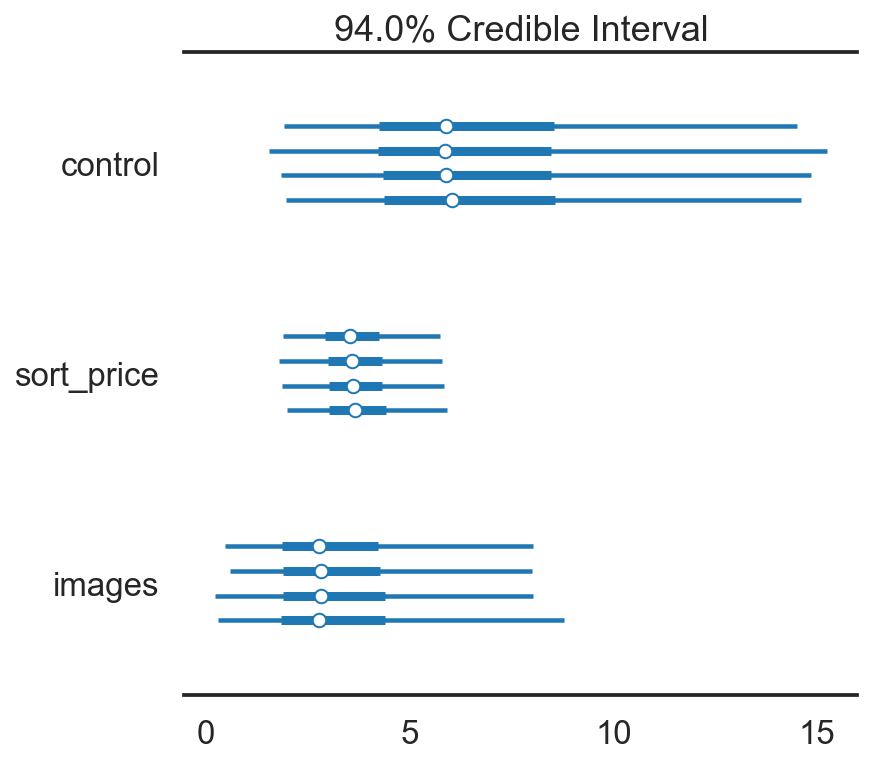

In [49]:
az.plot_forest(trace, var_names=['alpha'])
ax = plt.gca()
ax.set_yticklabels(reversed(['control', 'sort_price', 'images']))
plt.savefig('../assets/images/click.alpha.forest.png', dpi=300, transparent=True)

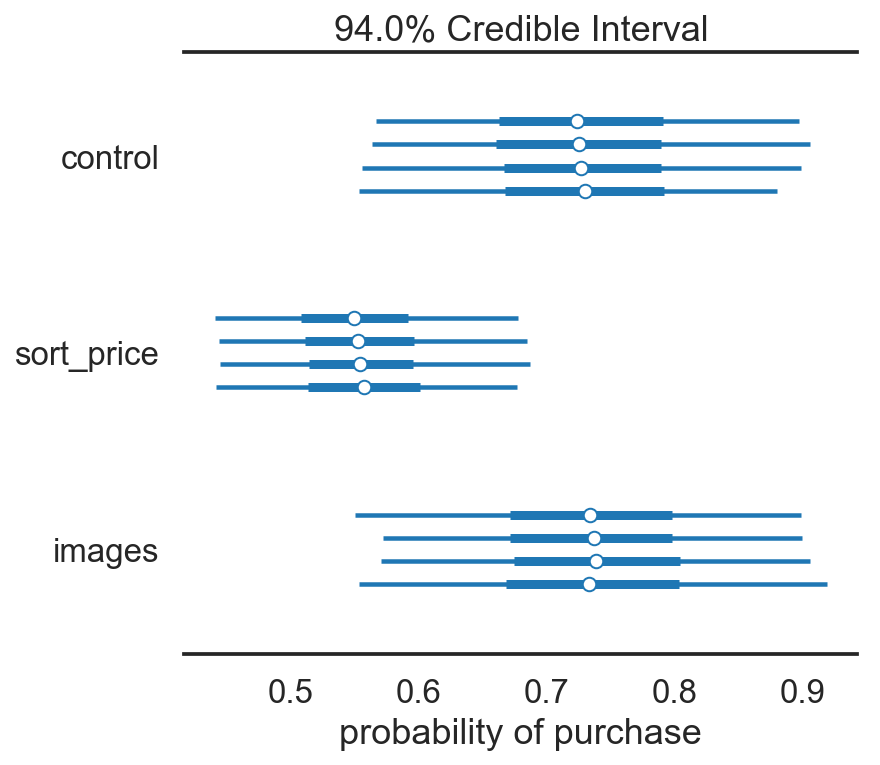

In [55]:
az.plot_forest(trace, var_names=['p_purchase'])
ax = plt.gca()
ax.set_yticklabels(reversed(['control', 'sort_price', 'images']))
ax.set_xlabel('probability of purchase')
plt.savefig('../assets/images/click.p_purchase.forest.png', dpi=300, transparent=True)